In [1]:
# imports
import os
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.cluster import KMeans

from scipy import stats

# local
import wrangle_zillow as w
import explore as e
import modeling as m

# Experimenting more with zillow

In [2]:
df = w.wrangle_zillow()
df = w.clean_outliers_qtl(df)
df = df.drop(columns=['trx_date','transactiondate'])
df = w.encode(df)
train,val,test = w.split_data(df)
train

yearbuilt   age  old_home  bathroomcnt  bedroomcnt  roomcnt  \
40811     1989.0  28.0     False          2.5         3.0      5.0   
32812     1950.0  67.0      True          3.0         3.0      6.0   
67398     1923.0  94.0      True          1.0         2.0      3.0   
56020     2008.0   9.0     False          2.5         4.0      7.0   
42105     1953.0  64.0      True          2.0         3.0      5.0   
...          ...   ...       ...          ...         ...      ...   
64756     1961.0  56.0      True          3.0         4.0      7.0   
70587     1968.0  49.0      True          2.0         4.0      8.0   
67662     1967.0  50.0      True          2.0         2.0      4.0   
74795     1979.0  38.0      True          2.0         2.0      4.0   
6861      1958.0  59.0      True          1.0         2.0      3.0   

       garagecarcnt  has_garage  calculatedfinishedsquarefeet    latitude  \
40811           2.0        True                        1200.0  33572695.0   
32812           1.0        True                        2013.0  33635390.0   
67398           0.0       False                        1458.0  34168270.0   
56020           2.0        True                        2042.0  34249393.0   
42105           0.0       False                        1169.0  33789326.0   
...             ...         ...                           ...         ...   
64756           0.0       False                        2499.0  34165566.0   
70587           2.0        True                        1715.0  34232429.0   
67662           0.0       False                        1108.0  33986600.0   
74795           1.0        True                        1084.0  34270400.0   
6861            0.0       False                         896.0  34073360.0   

       ...  heatingorsystemdesc_Baseboard heatingorsystemdesc_Central  \
40811  ...                              0                           0   
32812  ...                              0                           0   
67398  ...                              0                           1   
56020  ...                              0                           0   
42105  ...                              0                           0   
...    ...                            ...                         ...   
64756  ...                              0                           1   
70587  ...                              0                           0   
67662  ...                              0                           1   
74795  ...                              0                           0   
6861   ...                              0                           0   

       heatingorsystemdesc_Floor/Wall  heatingorsystemdesc_Forced air  \
40811                               0                               0   
32812                               0                               0   
67398                               0                               0   
56020                               0                               0   
42105                               1                               0   
...                               ...                             ...   
64756                               0                               0   
70587                               0                               0   
67662                               0                               0   
74795                               0                               0   
6861                                1                               0   

      heatingorsystemdesc_Gravity heatingorsystemdesc_Heat Pump  \
40811                           0                             0   
32812                           0                             0   
67398                           0                             0   
56020                           0                             0   
42105                           0                             0   
...                           ...                           ...   
64756             

In [3]:
# train_m,val_m,test_m = w.mm(train,val,test,scale=train.select_dtypes(exclude='object').columns)
train_s,val_s,test_s = w.std(train,val,test,scale=train.select_dtypes(exclude='object').columns)
# train_r,val_r,test_r = w.robs(train,val,test,scale=train.select_dtypes(exclude='object').columns)
train_s.head()

yearbuilt_s     age_s  old_home_s  bathroomcnt_s  bedroomcnt_s  \
40811     0.863068 -0.863068   -1.821949       0.330867      0.018149   
32812    -0.849722  0.849722    0.548863       0.920925      0.018149   
67398    -2.035500  2.035500    0.548863      -1.439304     -0.986929   
56020     1.697504 -1.697504   -1.821949       0.330867      1.023227   
42105    -0.717969  0.717969    0.548863      -0.259190      0.018149   

       roomcnt_s  garagecarcnt_s  has_garage_s  \
40811  -0.255283        1.474353      1.352093   
32812   0.311065        0.389410      1.352093   
67398  -1.387978       -0.695533     -0.739594   
56020   0.877412        1.474353      1.352093   
42105  -0.255283       -0.695533     -0.739594   

       calculatedfinishedsquarefeet_s  latitude_s  ...  \
40811                       -0.632996   -1.602433  ...   
32812                        0.429205   -1.371108  ...   
67398                       -0.295914    0.595055  ...   
56020                        0.467094    0.894374  ...   
42105                       -0.673498   -0.803132  ...   

       heatingorsystemdesc_Baseboard_s heatingorsystemdesc_Central_s  \
40811                           -0.013                     -0.880577   
32812                           -0.013                     -0.880577   
67398                           -0.013                      1.135619   
56020                           -0.013                     -0.880577   
42105                           -0.013                     -0.880577   

       heatingorsystemdesc_Floor/Wall_s  heatingorsystemdesc_Forced air_s  \
40811                         -0.474017                         -0.104562   
32812                         -0.474017                         -0.104562   
67398                         -0.474017                         -0.104562   
56020                         -0.474017                         -0.104562   
42105                          2.109627                         -0.104562   

      heatingorsystemdesc_Gravity_s heatingorsystemdesc_Heat Pump_s  \
40811                     -0.006949                       -0.004913   
32812                     -0.006949                       -0.004913   
67398                     -0.006949                       -0.004913   
56020                     -0.006949                       -0.004913   
42105                     -0.006949                       -0.004913   

      heatingorsystemdesc_None_s  heatingorsystemdesc_Radiant_s  \
40811                  -0.029493                      -0.018387   
32812                  -0.029493                      -0.018387   
67398                  -0.029493                      -0.018387   
56020                  -0.029493                      -0.018387   
42105                  -0.029493                      -0.018387   

       heatingorsystemdesc_Solar_s  heatingorsystemdesc_Yes_s  
40811                    -0.038402                   1.316022  
32812                    -0.038402                   1.316022  
67398                    -0.038402                  -0.759866  
56020                    -0.038402                   1.316022  
42105                    -0.038402                  -0.759866  

[5 rows x 48 columns]

#### Check cluster inertia based on scaler for lat long

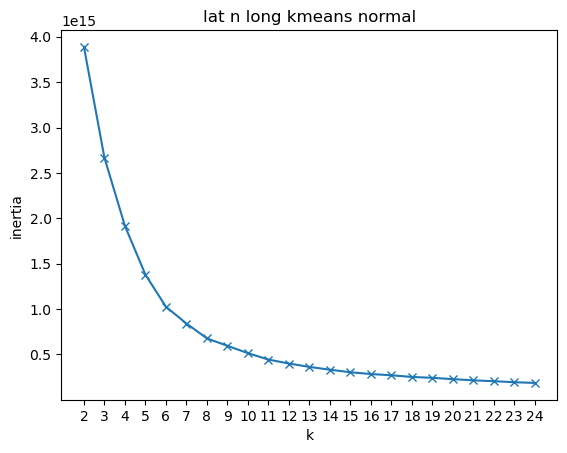

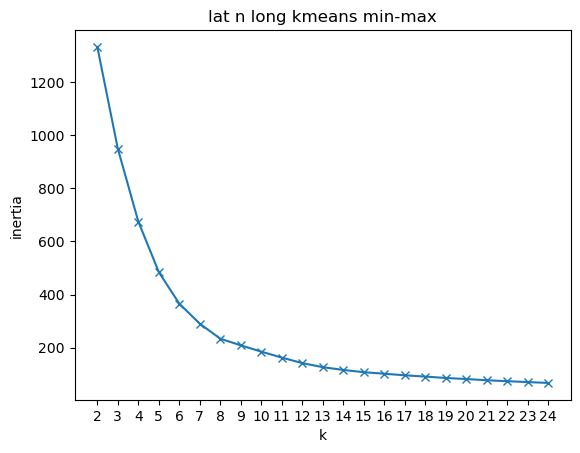

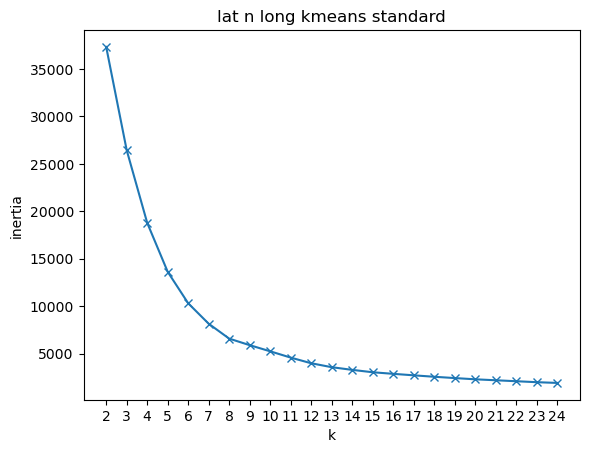

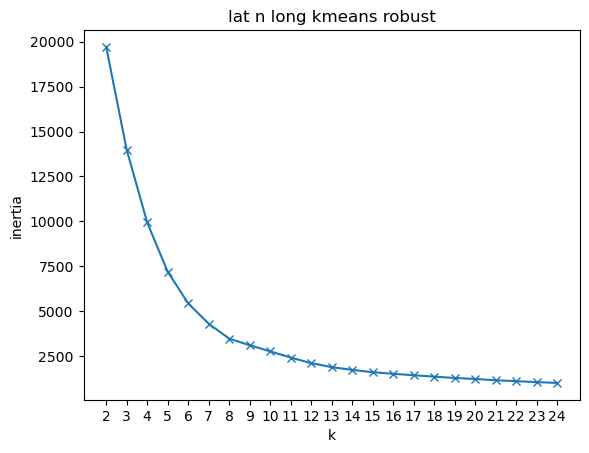

In [7]:
# train_ll,train_mll,train_sll,train_rll = train[['latitude','longitude']],train_m[['latitude_s','longitude_s']],train_s[['latitude_s','longitude_s']],train_r[['latitude_s','longitude_s']]
# pd.Series({k:KMeans(k,random_state=42).fit(train_ll).inertia_ for k in range(2,25)}).plot(marker='x')
# plt.xticks(range(2,25))
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.title('lat n long kmeans normal')
# plt.show()
# pd.Series({k:KMeans(k,random_state=42).fit(train_mll).inertia_ for k in range(2,25)}).plot(marker='x')
# plt.xticks(range(2,25))
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.title('lat n long kmeans min-max')
# plt.show()
# pd.Series({k:KMeans(k,random_state=42).fit(train_sll).inertia_ for k in range(2,25)}).plot(marker='x')
# plt.xticks(range(2,25))
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.title('lat n long kmeans standard')
# plt.show()
# pd.Series({k:KMeans(k,random_state=42).fit(train_rll).inertia_ for k in range(2,25)}).plot(marker='x')
# plt.xticks(range(2,25))
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.title('lat n long kmeans robust')
# plt.show()

#### Check lat long cluster to prop value 

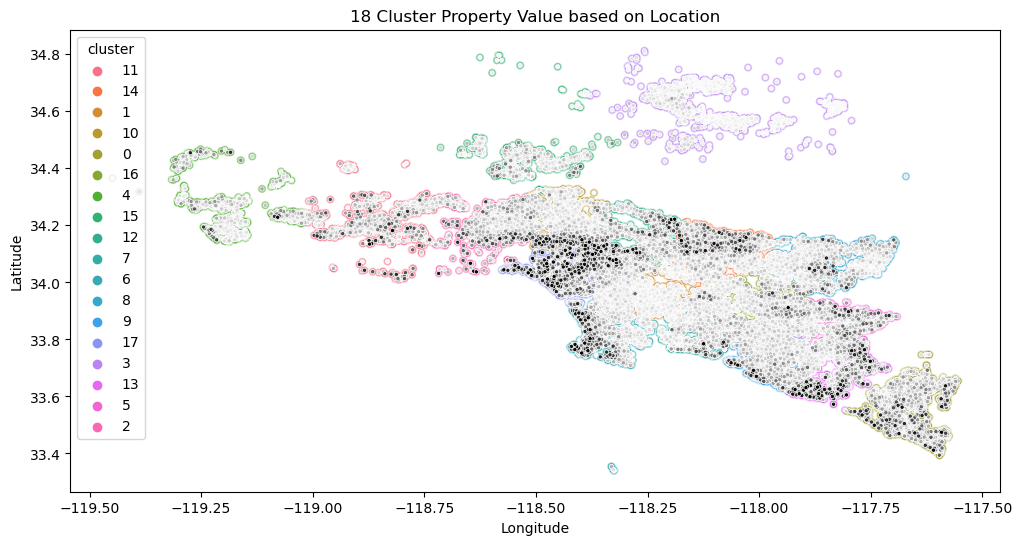

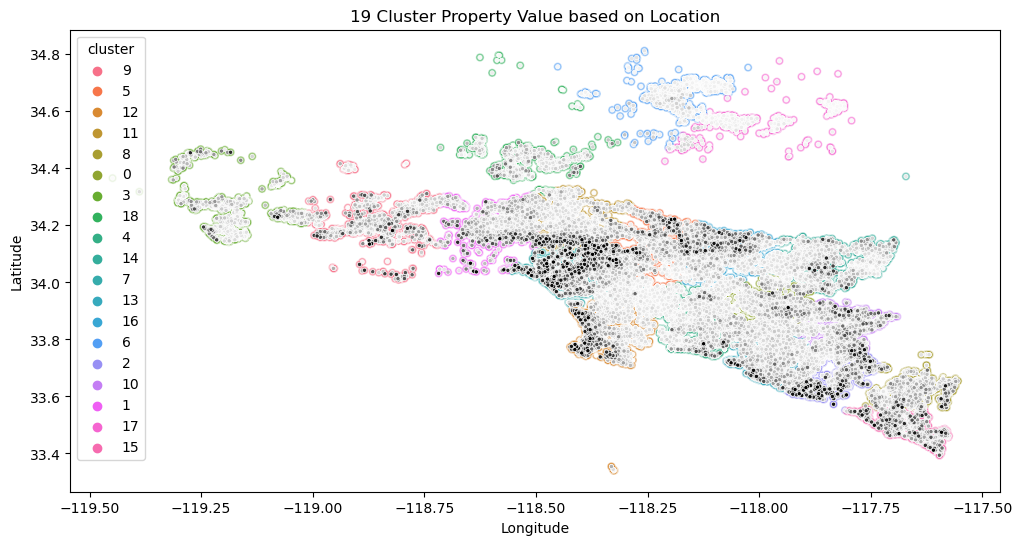

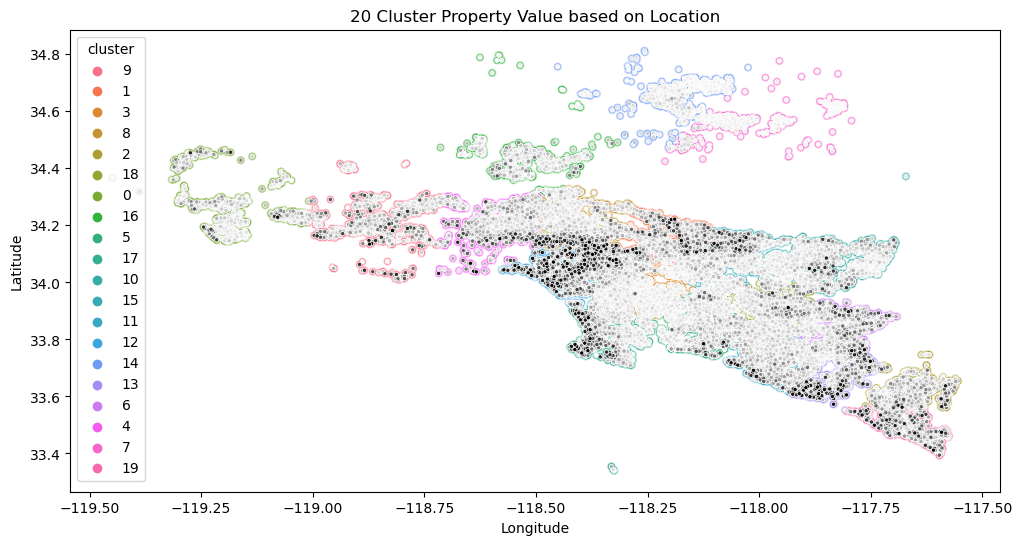

In [18]:
# for n in range(18,21):
#     km = KMeans(n_clusters=n,random_state=42)
#     km.fit(train_ll)
#     train_ll = train_ll.assign(cluster = km.predict(train_ll))
#     train_ll.cluster = train_ll.cluster.astype(str)
#     # make the size
#     plt.figure(figsize=[12,6])
#     # plot prop value based on lat long
#     # make xy label scale smaller
#     p = train.copy()
#     p = p.assign(cluster=train_ll.cluster)
#     p = p.assign(lat=p.latitude/1000000)
#     p = p.assign(long=p.longitude/1000000)
#     p = p.sort_values('taxvaluedollarcnt')
#     # cluster kmeans
#     sns.scatterplot(data=p, y='lat', x='long', alpha=.6, hue='cluster')
#     # generic legend example
#     sns.scatterplot(data=p,y='lat',x='long',hue='taxvaluedollarcnt',palette='Greys',alpha=1,marker='.',legend=False)
#     # label generic legend
#     # plt.legend(title='Prop Value',labels=['','$400k','$800k','$1.2m','$1.6m'])
#     # give it a name
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.title(f'{n} Cluster Property Value based on Location')
#     plt.show()


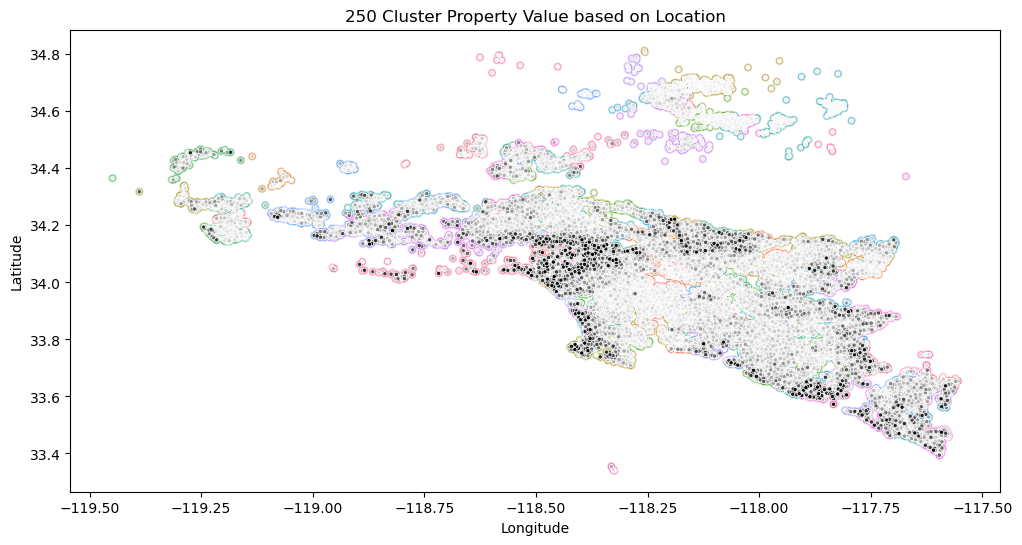

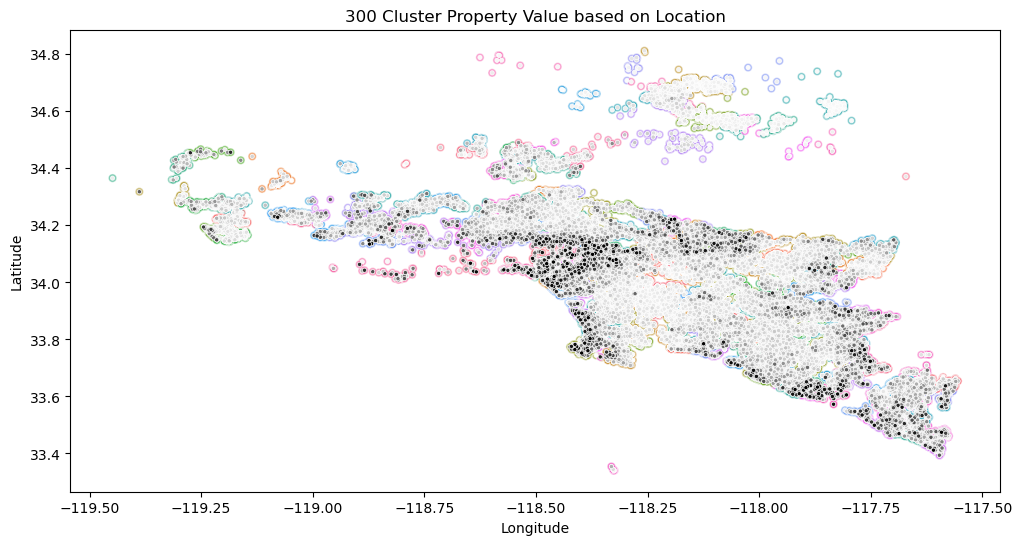

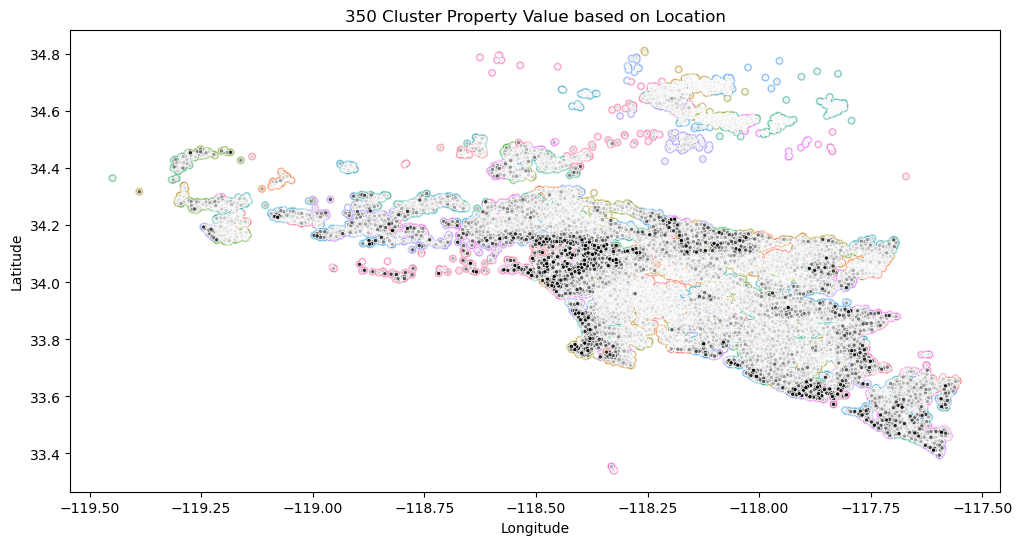

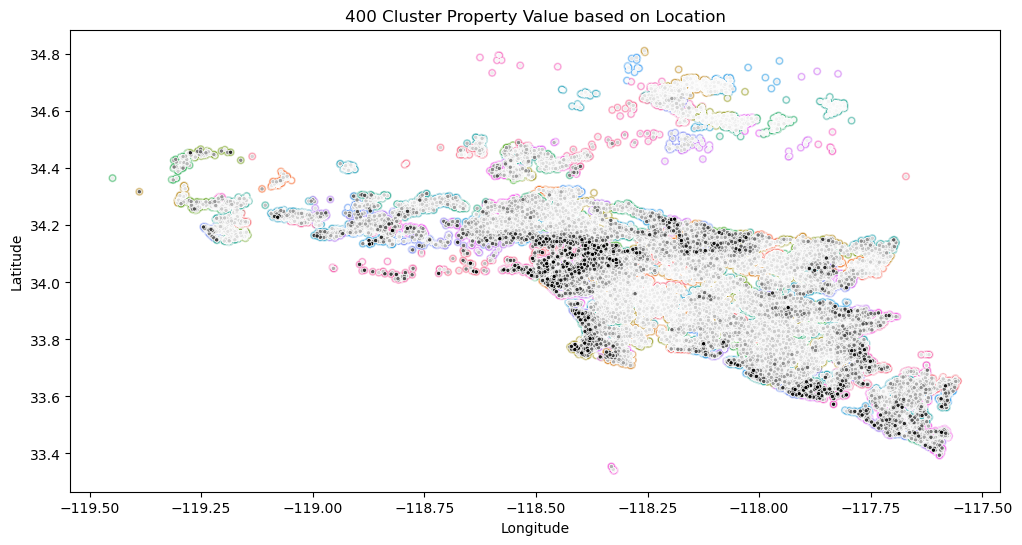

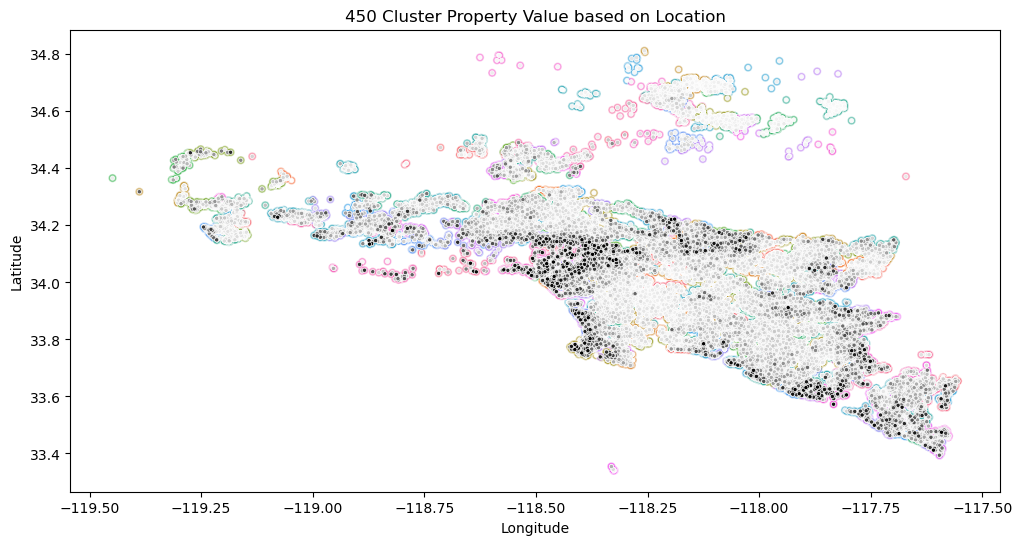

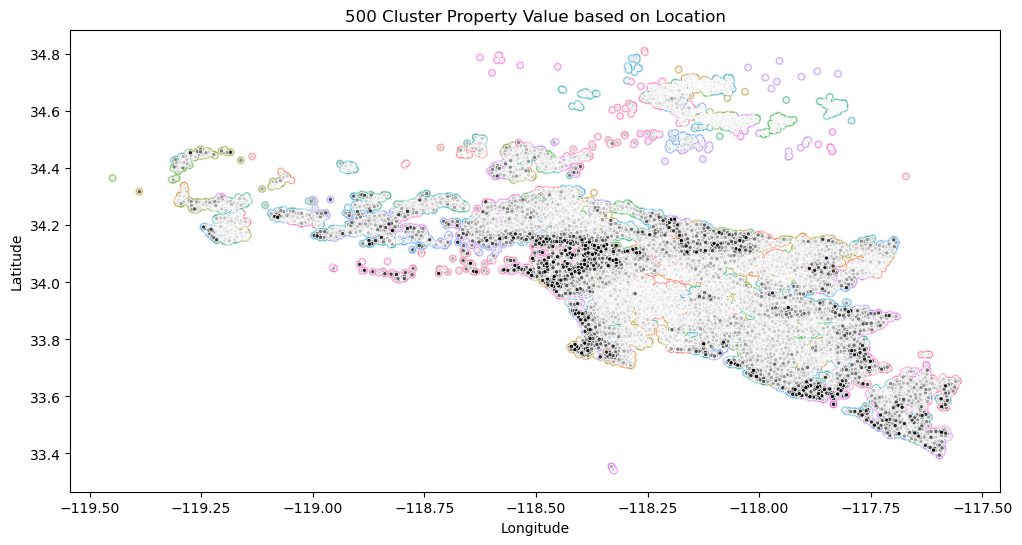

In [40]:
# # for n in range(3,21):
# for n in [250,300,350,400,450,500]:
#     km = KMeans(n_clusters=n,random_state=42)
#     km.fit(train_mll)
#     train_mll = train_mll.assign(cluster = km.predict(train_mll))
#     train_mll.cluster = train_mll.cluster.astype(str)
#     # make the size
#     plt.figure(figsize=[12,6])
#     # plot prop value based on lat long
#     # make xy label scale smaller
#     p = train.copy()
#     p = p.assign(cluster=train_mll.cluster)
#     p = p.assign(lat=p.latitude/1000000)
#     p = p.assign(long=p.longitude/1000000)
#     p = p.sort_values('taxvaluedollarcnt')
#     # cluster kmeans
#     sns.scatterplot(data=p, y='lat', x='long', alpha=.6, hue='cluster',legend=False)
#     # generic legend example
#     sns.scatterplot(data=p,y='lat',x='long',hue='taxvaluedollarcnt',palette='Greys',alpha=1,marker='.',legend=False)
#     # label generic legend
#     # plt.legend(title='Prop Value',labels=['','$400k','$800k','$1.2m','$1.6m'])
#     # give it a name
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.title(f'{n} Cluster Property Value based on Location')
#     plt.show()


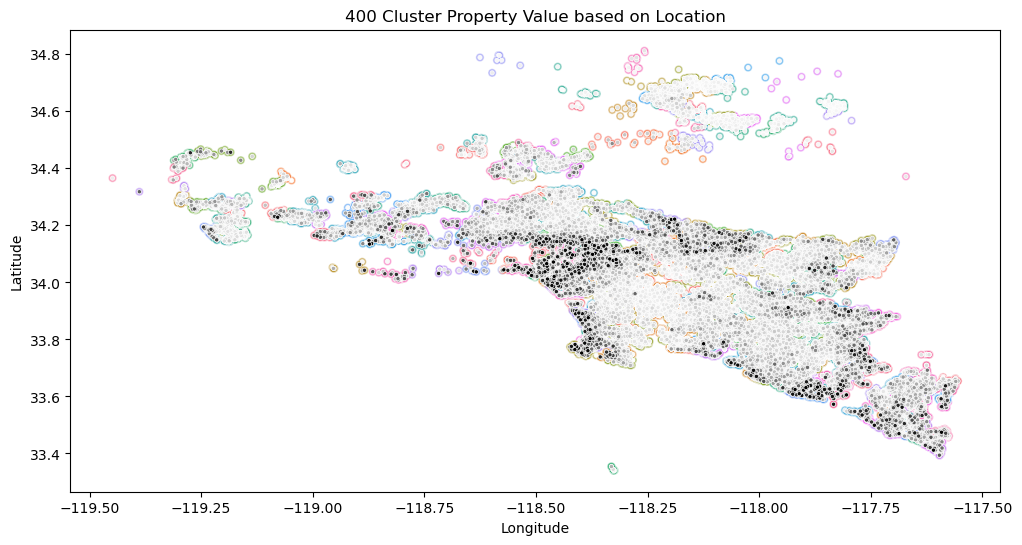

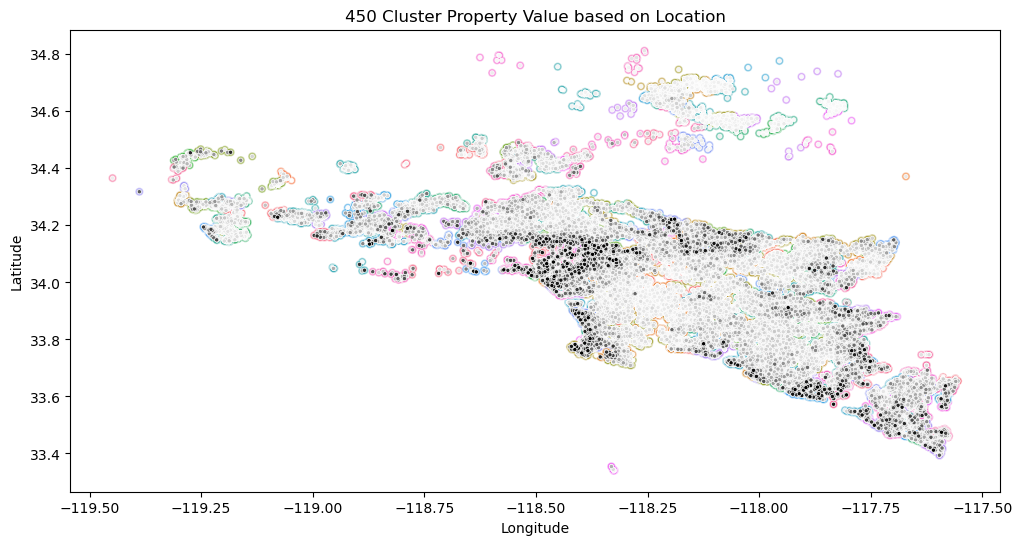

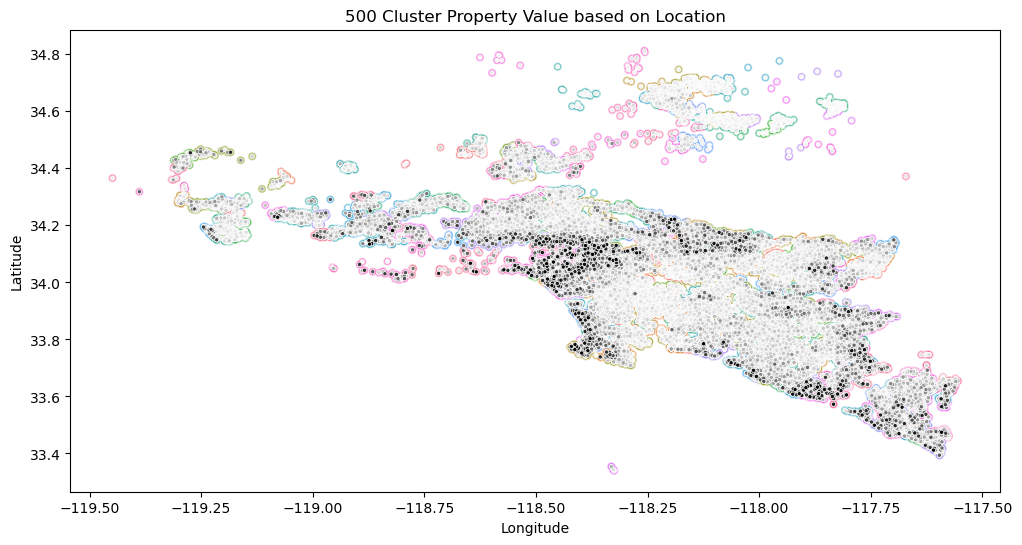

In [43]:
# for n in range(14,21):
for n in [400,450,500]:
    km = KMeans(n_clusters=n,random_state=42)
    km.fit(train_sll)
    train_sll = train_sll.assign(cluster = km.predict(train_sll))
    train_sll.cluster = train_sll.cluster.astype(str)
    # make the size
    plt.figure(figsize=[12,6])
    # plot prop value based on lat long
    # make xy label scale smaller
    p = train.copy()
    p = p.assign(cluster=train_sll.cluster)
    p = p.assign(lat=p.latitude/1000000)
    p = p.assign(long=p.longitude/1000000)
    p = p.sort_values('taxvaluedollarcnt')
    # cluster kmeans
    sns.scatterplot(data=p, y='lat', x='long', alpha=.6, hue='cluster',legend=False)
    # generic legend example
    sns.scatterplot(data=p,y='lat',x='long',hue='taxvaluedollarcnt',palette='Greys',alpha=1,marker='.',legend=False)
    # label generic legend
    # plt.legend(title='Prop Value',labels=['','$400k','$800k','$1.2m','$1.6m'])
    # give it a name
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{n} Cluster Property Value based on Location')
    plt.show()


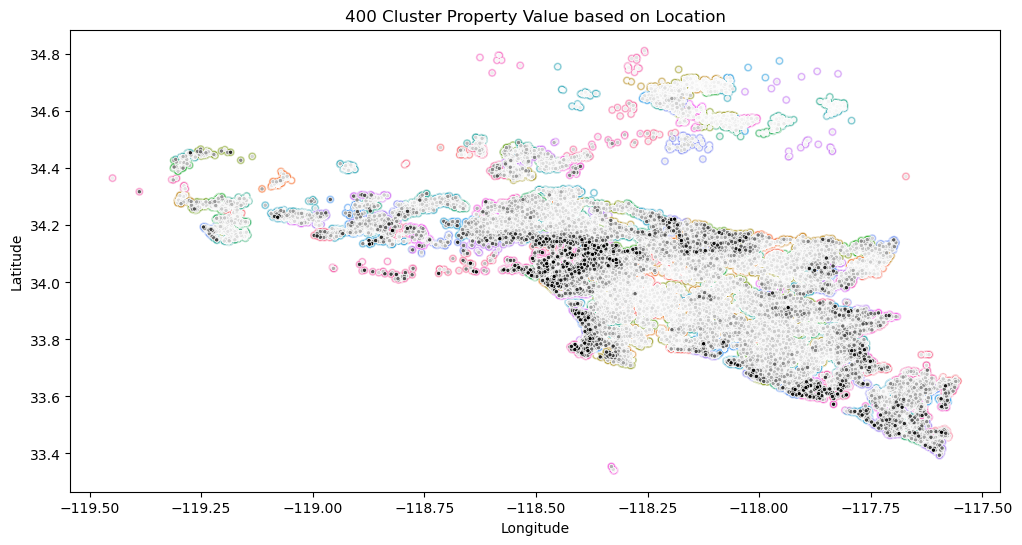

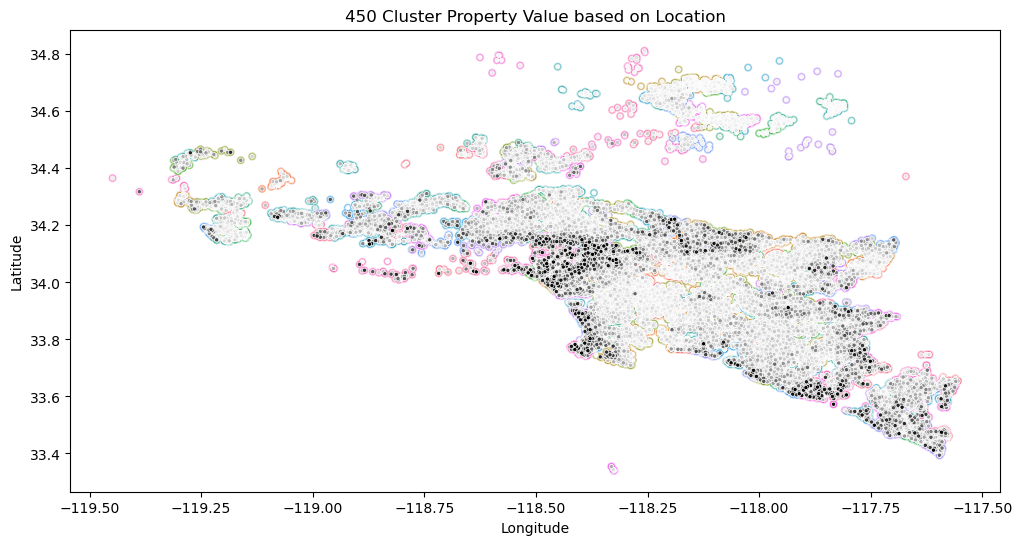

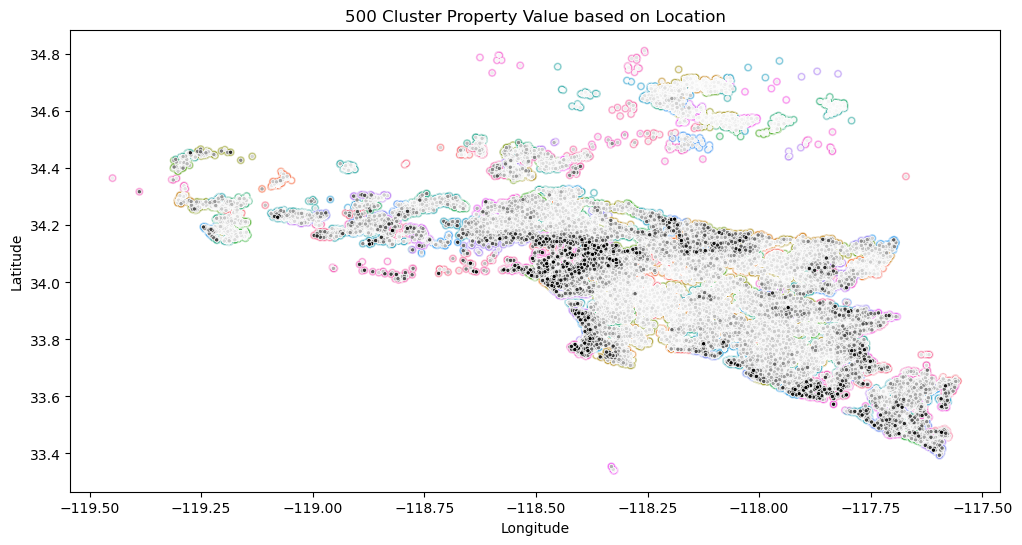

In [44]:
# # for n in range(14,21):
# for n in [400,450,500]:
#     km = KMeans(n_clusters=n,random_state=42)
#     km.fit(train_rll)
#     train_rll = train_rll.assign(cluster = km.predict(train_rll))
#     train_rll.cluster = train_rll.cluster.astype(str)
#     # make the size
#     plt.figure(figsize=[12,6])
#     # plot prop value based on lat long
#     # make xy label scale smaller
#     p = train.copy()
#     p = p.assign(cluster=train_rll.cluster)
#     p = p.assign(lat=p.latitude/1000000)
#     p = p.assign(long=p.longitude/1000000)
#     p = p.sort_values('taxvaluedollarcnt')
#     # cluster kmeans
#     sns.scatterplot(data=p, y='lat', x='long', alpha=.6, hue='cluster',legend=False)
#     # generic legend example
#     sns.scatterplot(data=p,y='lat',x='long',hue='taxvaluedollarcnt',palette='Greys',alpha=1,marker='.',legend=False)
#     # label generic legend
#     # plt.legend(title='Prop Value',labels=['','$400k','$800k','$1.2m','$1.6m'])
#     # give it a name
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.title(f'{n} Cluster Property Value based on Location')
#     plt.show()


#### Check metrics of clusters

In [82]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

# davies_bouldin_score(X,KMeans.labels_)
# calinski_harabasz_score(X,KMeans.labels_)
# silhouette_score(X, KMeans.labels_, metric='euclidean')

In [89]:
for n in [3,4,5,6,7,8]:
    km = KMeans(n_clusters=n,random_state=42)
    km.fit(train_ll)
    # train_ll = train_ll.assign(cluster = km.predict(train_ll))
    dbs = davies_bouldin_score(train_ll,km.labels_)
    chs = calinski_harabasz_score(train_ll,km.labels_)
    sls = silhouette_score(train_ll,km.labels_)
    print(f'clusters:{n}\ndbs:{dbs}\nchs:{chs}\nsls:{sls}\n')

clusters:3
dbs:0.7568791869894226
chs:45867.314043395185
sls:0.439744481882002

clusters:4
dbs:0.8801242935201352
chs:47967.23918871977
sls:0.39983046346665646

clusters:5
dbs:0.7030467061488487
chs:54016.893683262344
sls:0.4296919933798301

clusters:6
dbs:0.7434407085338882
chs:60943.84085724902
sls:0.4160011440377417

clusters:7
dbs:0.7452458325240381
chs:63455.358264902745
sls:0.4242156557349208

clusters:8
dbs:0.7386762755489192
chs:68986.98656410933
sls:0.42909210346064286



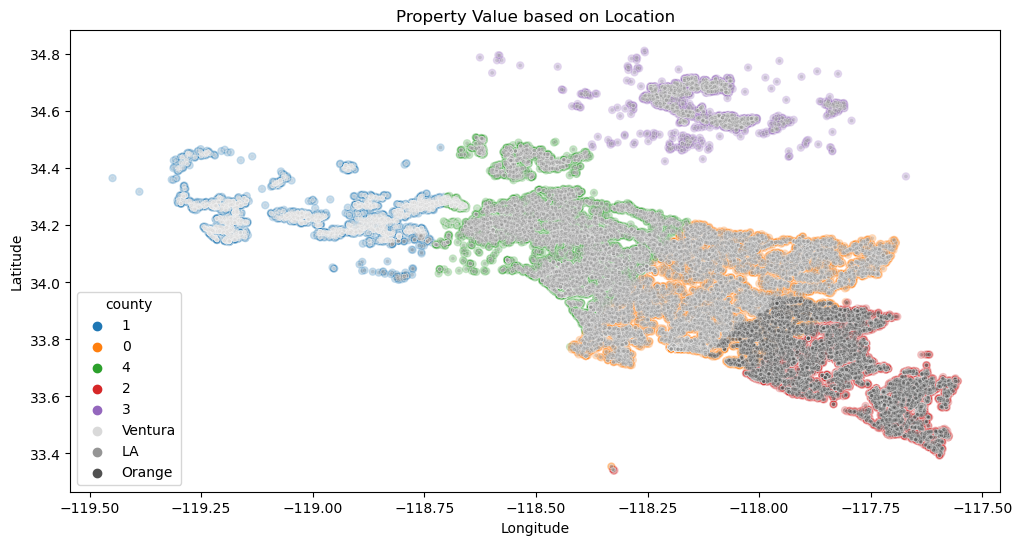

In [94]:
km = KMeans(n_clusters=5,random_state=42)
km.fit(train_ll)
train_ll = train_ll.assign(cluster = km.predict(train_ll))
train_ll.cluster = train_ll.cluster.astype(str)
# make the size
plt.figure(figsize=[12,6])
# plot prop value based on lat long
# make xy label scale smaller
p = train.copy()
p = p.assign(cluster=train_ll.cluster)
p = p.assign(lat=p.latitude/1000000)
p = p.assign(long=p.longitude/1000000)
p = p.sort_values('taxvaluedollarcnt')
# cluster kmeans
sns.scatterplot(data=p, y='lat', x='long', hue='cluster',alpha=.3,legend=True)
# generic legend example
sns.scatterplot(data=p,y='lat',x='long',hue='county',palette='Greys',alpha=.3,marker='.')
# label generic legend
# plt.legend(labels=['clusters','Prop Val','$400k','$800k','$1.2m','$1.6m'])
# give it a name
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Property Value based on Location')
plt.show()